In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget

In [2]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation

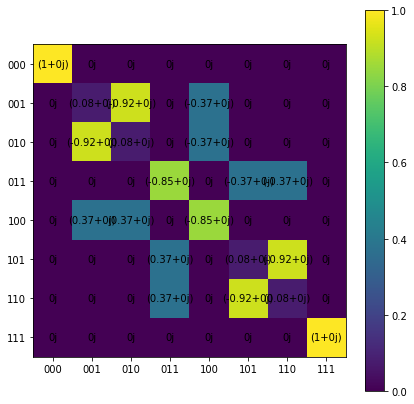

In [3]:
#using our same metrics as before using ratio of coupling strengths, investigate the relative costs of our 3Q gates
from src.hamiltonian import CirculatorHamiltonian
#v_nn = np.sqrt(2) * np.pi / np.arccos(1 / np.sqrt(3)) #w-state
v_nn = 4/np.sqrt(2) #1.5iswap
v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0]
#v_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / v_nn, np.pi / v_nn, np.pi / v_nn]
_array = CirculatorHamiltonian.construct_U(*v_params,t=1.6442677715360021) #w-state
#_array = CirculatorHamiltonian.construct_U(*v_params,t=1) #completed DIV
plotMatrix(_array);

In [4]:
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator
from qiskit import transpile
def foo(qc_p: QuantumCircuit, t_max =1, invert=False, state_prep=None):
    #pass in a parameterized quantum circuit, only parameter should be duration of the target unitary
    data = []
    t_range = np.linspace(0,t_max,40)
    for t_el in t_range:

        temp = qc_p.assign_parameters(
                {parameter: i for parameter, i in zip(qc_p.parameters, [t_el])}
            )

        #output_state = np.matmul(unitary.full(),np.array(input_state))
        # backend = BasicAer.get_backend('statevector_simulator') # the device to run on
        #result = backend.run(transpile(qc, backend)).result()

        #add this invert check, bc sometimes weve built the template backwards when doing an undo op
        if invert:
            #temp = np.matrix.getH(Operator(temp).data)
            temp = temp.inverse()
        
        #adding barrier in this weird way to not directly modify state_prep circuit
        b = QuantumCircuit(3)
        b.barrier()
        temp = b.compose(temp)
        if not state_prep is None:
            temp = state_prep.compose(temp)
        output_state = Statevector(temp)

        data.append([np.abs(el)**2 for el in output_state])

    for s_index in range(len(data[0])):
        temp_data = np.array(data).T[s_index]
        if any([el > 0 for el in temp_data]): 
            plt.plot(t_range, temp_data, label=r"$|$" + f"{bin(s_index)[2:].zfill(3)}" + r"$\rangle$", marker='.', dashes=(5, s_index))
    # plt.plot(t_range, cost_data)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("State Probability")
    plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    print("final state:",data[-1])
    return temp

final state: [0.0, 0.25, 0.25, 0.0, 0.4999999999999999, 0.0, 0.0, 0.0]


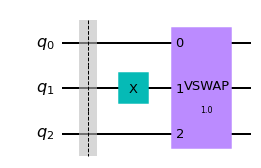

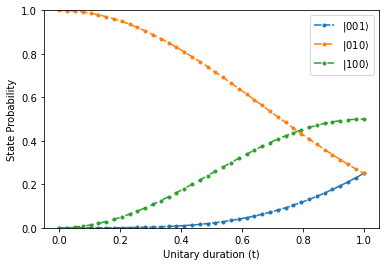

In [5]:
qc = QuantumCircuit(3)
qc.x(1)
t_param = Parameter('t')
from src.utils.custom_gates import VSwap
qc.append(VSwap(t_param), [0,1,2])
foo(qc).draw(output='mpl')

The Delta-iSwap is difficult to find entangled states for. Here is a costly GHZ-state:

final state: [0.4999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4999999999999999]


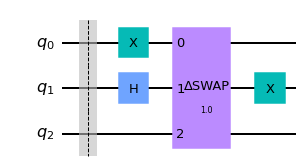

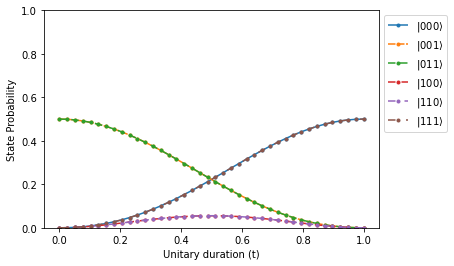

In [6]:
from src.utils.custom_gates import DeltaSwap
from src.hamiltonian import CirculatorHamiltonian
qc = QuantumCircuit(3)
# nn = 3 * np.sqrt(3) / 2
# v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
qc.x(0)
qc.h(1)
qc.append(DeltaSwap(Parameter('t')), (0,1,2))
qc.x(1)
foo(qc).draw(output='mpl')

Here is a Delta-iSwap finding the W-state from Martinis paper

final state: [0.0, 0.22222222222222238, 0.22222222222222243, 0.0, 0.5555555555555554, 0.0, 0.0, 0.0]


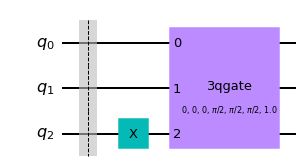

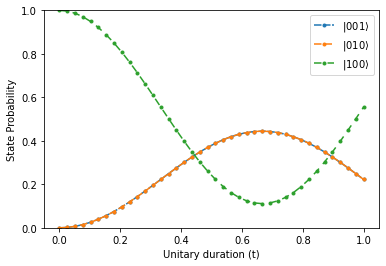

In [7]:
from src.utils.custom_gates import CirculatorSNAILGate
qc= QuantumCircuit(3)
qc.x(2)
qc.append(CirculatorSNAILGate(0,0,0, np.pi/2, np.pi/2, np.pi/2, Parameter('t')), (0,1,2))
foo(qc).draw(output='mpl')

The following V-iSwap gate is an interesting example because it shows both the W-State and the ~~GHZ-state created from the same input~~. My mistake, I saw 2 states go to equal probability, but this is not enough for a GHZ-state, needs to be |000> and |111> states specifically!

final state: [0.0, 0.5000000000000001, 0.5000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0]


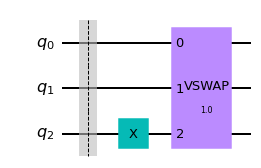

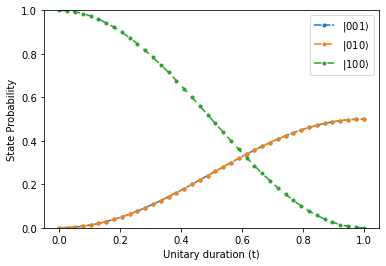

In [8]:
# v_nn = 4/np.sqrt(2) #1.5iswap
# v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
# foo_plot2(v_params).draw(output='mpl')
qc= QuantumCircuit(3)
qc.x(2)
qc.append(VSwap(Parameter('t')), (0,1,2))
foo(qc).draw(output='mpl')

It is difficult to know when we have the most cost-effective construction of an entangled state. A way to approach this problem differently, is to instead start with an entangled state, and run the gate while plotting mutual information - which should be 0 for a non-entangled state. This way we can observe states independent of 1Q gates, but by a pure measure of entanglement.

In [9]:
# """Use plots of mutual information to determine entanglement"""
# #Idea: run the gate in reverse, and when mutual information is 0, no longer entangled
# v_nn = 4/np.sqrt(2) #1.5iswap
# v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
# qc = QuantumCircuit(3)

# from qiskit import transpile, BasicAer, QuantumCircuit
# logger.setLevel(logging.WARNING)
# def foo_plot3(v_params, prep_state='w'):
#     data = []
#     cost_data = []
#     unit_cost = sum(v_params[-3:])/(np.pi/2) # XXX the g-terms
#     t_range = np.linspace(0,1,40)
#     for t_el in t_range:
#         qc = QuantumCircuit(3)

#         if prep_state =="ghz":
#         # #GHZ-state prep
#             qc.h(0)
#             qc.cx(0, 1)
#             qc.cx(0, 2)
#         #######

#         #W-state prep
#         elif prep_state=="w":
#             qc.ry(2*np.arccos(1/np.sqrt(3)),0)
#             qc.ch(0,1)
#             qc.cx(1,2)
#             qc.cx(0,1)
#             qc.x(0)
#         else:
#             raise("invalid prep state")
            
#         #####
#         #ghz from delta
#         qc.x(1)
        
#         #w from delta
#         #qc.rz(4*np.pi/3, 1)
        
#         unitary = CirculatorHamiltonian.construct_U(*v_params,t=t_el)
#         qc.unitary(unitary, [0,1,2])

#         #ghz from delta
#         qc.h(1)
#         qc.x(0)

#         #w from delta
#         #qc.x(1)

#         #w from vswap
#         #qc.x(2)
        

#         state = Statevector(qc)
#         state1 = partial_trace(state, [0])
#         state2 = partial_trace(state, [1])
#         state3 = partial_trace(state, [2])
        
        
#         #data.append([mutual_information(state1), mutual_information(state2), mutual_information(state3)])
#         #data.append([concurrence(state1), concurrence(state2), concurrence(state3)])
#         #data.append([sum([entanglement_of_formation(state1), entanglement_of_formation(state2), entanglement_of_formation(state3)])])
#         data.append([sum([mutual_information(state1), mutual_information(state2), mutual_information(state3)])])
#         cost_data.append(unit_cost*t_el)
#     for s_index in range(len(data[0])):
#         temp_data = np.array(data).T[s_index]
#         if any([el > 0 for el in temp_data]): 
#             plt.plot(t_range, temp_data, label=f"S{s_index}", marker='.', dashes=(5, s_index))
#     plt.plot(t_range, cost_data)
#     plt.legend()
#     plt.xlabel("Unitary duration (t)")
#     plt.ylabel("Entanglement Monotone")
#     #plt.ylim([0, 1])
#     #plt.rcParams["figure.figsize"] = (12,8)
#     print("final state:",data[-1])
#     print("best state:", t_range[np.argmin(data)], min(data))
#     return qc

# # backend = BasicAer.get_backend('statevector_simulator')
# # result = backend.run(transpile(qc, backend)).result()
# # output_state = result.get_statevector(qc)
# # print(output_state)

# # qc.measure_all()
# # from qiskit.visualization import plot_histogram
# # backend = BasicAer.get_backend('qasm_simulator')
# # job = execute(qc, backend)
# # plot_histogram(job.result().get_counts())

This plot shows at ~.6, the mutual informations all go to 1, this is where the W-state is created by this gate.

In [10]:
# # foo_plot3(v_params) #GHZ state has this messy result
# v_nn = 4/np.sqrt(2) #1.5iswap
# v_params = [np.pi / 2, np.pi / 2, 0, np.pi / v_nn, np.pi / v_nn, 0] #V-swap
# foo_plot3(v_params).draw(output='mpl')

In [11]:
# # foo_plot3(v_params) #GHZ state has this messy result
# nn = 3 * np.sqrt(3) / 2
# v_params = [np.pi / 2, -np.pi / 2, np.pi / 2, np.pi / nn, np.pi / nn, np.pi / nn]   #smiley
# foo_plot3(v_params, prep_state='ghz').draw(output='mpl')

Now I am going to try and combine entanglement with variational template. Use an entanglement monotone as the cost function

In [8]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

import numpy as np
from src.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation

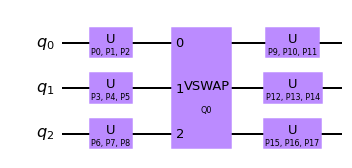

In [9]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import VSwap
basis = CircuitTemplateV2(n_qubits=3, base_gates = [VSwap], edge_params=[[(0,1,2)]])
basis.build(1)
basis.spanning_range = range(1,2)
basis.circuit.draw(output='mpl')

In [10]:
ub = 0.7
basis.add_bound("Q0", min=0, max=ub)

In [11]:
from src.cost_function import MutualInformation, MutualInformationSquare, BasicCostInverse
objective = MutualInformation(state='w')
#unitary_objective = BasicCostInverse()
from src.optimizer import TemplateOptimizer
#optimizer = TemplateOptimizer(basis=basis, objective=objective, use_callback=True, override_fail=True)
optimizer = TemplateOptimizer(basis=basis, objective=objective, use_callback=True, override_fail=True)

Now note the optimzer for entanglement should ignore the sample since it isn't used in the cost function

In [12]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1) #don't care

# from src.sampler import GateSample
# from qiskit.extensions import UnitaryGate
# w = QuantumCircuit(3)
# w.ry(2*np.arccos(1/np.sqrt(3)),0)
# w.ch(0,1)
# w.cx(1,2)
# w.cx(0,1)
# w.x(0)
# from qiskit.quantum_info import Operator
# w_state = Operator(w).data
# w_gate = UnitaryGate(w_state)
# sampler = GateSample(gate=w_gate, n_samples=1)

s = [s for s in sampler][0]
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 1
INFO:root:Break on cycle 1
INFO:root:Loss=7.189317649480638e-11
INFO:root:Success: (0.49741881, 0.30805173, 0.042267)


Entangled Fidelity 7.189317649480638e-11


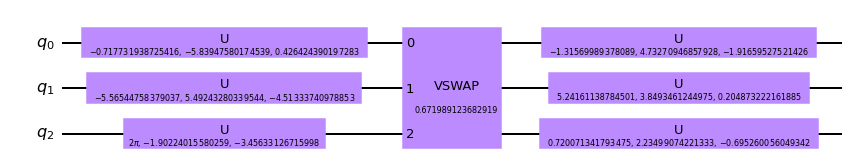

In [13]:
#show the result of training
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)
print("Entangled Fidelity", ret.loss_result)
circuit.draw(output='mpl')

In [14]:
from qiskit.circuit import Parameter
def unbind_parameters(qc):
    out = qc.copy()
    for instr, qargs, cargs in out:
        if instr.params and instr.name =='vswap' or instr.name == "Δswap":
            # num_params = len(instr.params)
            # pvec.resize(len(pvec) + num_params)
            instr.params = [Parameter('t')]
        #for 3Q, we only want to free the last parameter
        #the way is written should be safe for both cases
        #but I am keeping in elif for readability/safety
        elif instr.params and instr.name == "3QGate":
            instr.params[-1] = Parameter('t')
    return out

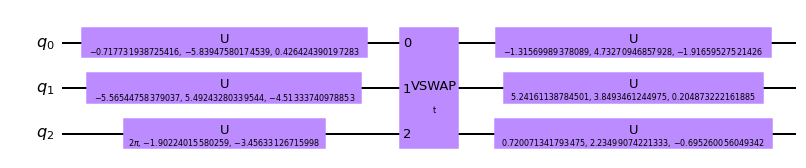

In [15]:
#unbind the time parameter in order to make plots
qc2 = circuit.copy()
qc3 = unbind_parameters(qc2)
#update parameter table
from qiskit.converters import *
qc3 = dag_to_circuit(circuit_to_dag(qc3))
# qc3.parameters
qc3.draw(output='mpl')

In [16]:
from src.cost_function import EntanglementCostFunction
from scipy.optimize import curve_fit
def foo_plot4(qc_p, cost_function:EntanglementCostFunction,t_max=1.5*ub, ret_t=None):
    data = []
    t_range = np.linspace(0,t_max,100)

    def f(t):
        qc2 = qc_p.assign_parameters(
            {parameter: i for parameter, i in zip(qc_p.parameters, [t])}
        )
        val = cost_function.entanglement_monotone(qc2)
        #val = cost_function.unitary_fidelity(w_gate, Operator(qc2))
        return val

    for t_el in t_range:
        data.append(f(t_el))
        
    plt.plot(t_range, data, marker='.')

    #hightlight the optimizer's t value
    if not ret_t is None:
        plt.vlines(ret_t, ymin=0, ymax=max(data), colors='orange', linestyles='--')
        #NOTE also functions to load in optimal into cost_function for prepping the returned circuit
        data.append(f(ret_t))

    # plt.legend()
    plt.xlabel("Unitary duration (t)")
    plt.ylabel("Entanglement Monotone")
    #plt.ylim([0, 1])
    #plt.rcParams["figure.figsize"] = (12,8)
    #print("best state:", t_range[np.argmin(data)], min(data))
    print("best state:", ret_t, data[-1])
    return cost_function.full, data #returns the circuit for displaying

best state: 0.671989123682919 7.189317649480638e-11


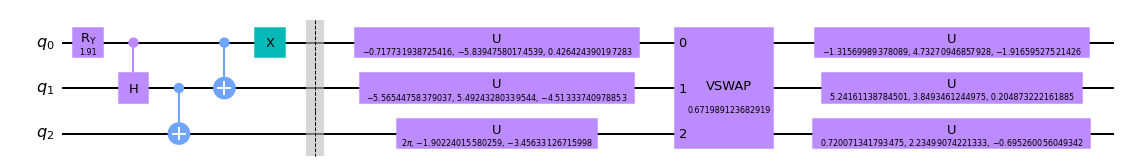

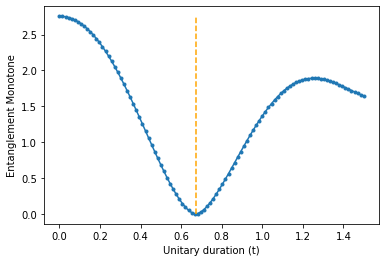

In [17]:
full_qc3, data_qc3 = foo_plot4(qc3, cost_function=objective, t_max=1.5, ret_t = ret.Xk[-1])
full_qc3.draw(output='mpl')

In [18]:
#1. We can automatically create the state preparation part of the circuit like this
# what you find when transpiling is that the left over numerical inprecision will use a tiny amount of entangling
# we can verify using entropy measures like entropy of entanglement and see that it actually IS a product state up to 1e-12 accuracy
# we can instead just build the product state input ourselves manually
# TODO ideally we implement some resynthesis clean up that finds a cleaner solution, maybe a small brute force search over reduced discrete gate set?
s = Statevector(full_qc3)
init = QuantumCircuit(3)
init.initialize(s, (0,1,2));
# init_t = transpile(init, basis_gates=['rx', 'rz', 'cx'])
# init_t.draw(output='mpl')

final state: [0.0021934497568854294, 0.4694485944803017, 0.46944824932552837, 8.83886916799421e-07, 0.026290867201333067, 0.01617321608142598, 0.01617321342151599, 0.00027152584609214947]


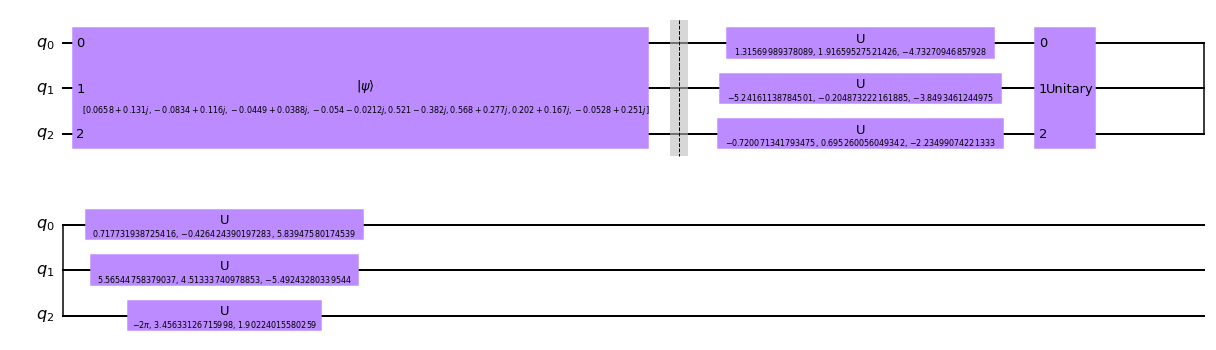

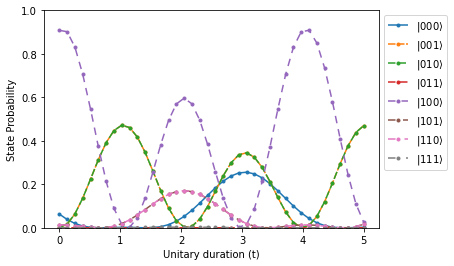

In [19]:
#verify state creation
#first, need to recover the final product state from the trained circuit to feed as an input into the reversed creation

#second, can plot now
# foo(qc3, t_max=ret.Xk[-1], invert=True).draw(output='mpl')
#foo(qc3, t_max=5, invert=True).draw(output='mpl')
foo(qc3, t_max=5, invert=True, state_prep=init).draw(output='mpl')

In [20]:
#Here we are building the state prepartion part of the circuit using traces such that it only uses 1Q gates
# recall if we use the transpiler, there will be 2Q gates from numerical imprecision leftover from the optimizer
from qiskit.extensions import UnitaryGate
def recover_final_state_prep(qc):
    s = Statevector(qc)
    qc1_prep = QuantumCircuit(3)
    for qubit_index in range(3):
        qs = [0,1,2]
        qs.remove(qubit_index)
        q_state = partial_trace(s, qs).to_statevector()
        a, b = q_state
        u = [[a,np.conj(b)], [b, -np.conj(a)]]
        qc1_prep.append(UnitaryGate(u), [qubit_index])
    return qc1_prep

In [21]:
qc1_prep = recover_final_state_prep(full_qc3)
# qc1_prep.draw(output='mpl')
# qc1_prep_t = transpile(qc1_prep, basis_gates=['rx', 'rz', 'cx'])
# qc1_prep_t.draw(output='mpl')

final state: [0.002193460286911274, 0.46944893147392486, 0.4694478619852307, 8.838496285131694e-07, 0.026290993275045565, 0.016173189235407212, 0.016173145252051106, 0.0002715346418008392]


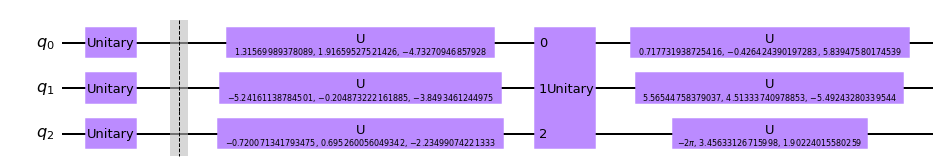

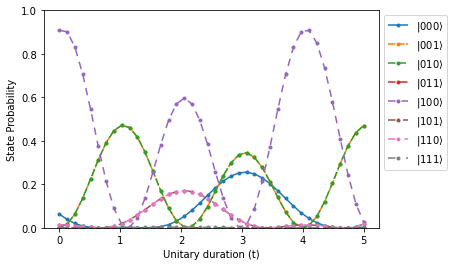

In [22]:
#verify state creation
#first, need to recover the final product state from the trained circuit to feed as an input into the reversed creation

#second, can plot now
# foo(qc3, t_max=ret.Xk[-1], invert=True).draw(output='mpl')
#foo(qc3, t_max=5, invert=True).draw(output='mpl')
foo(qc3, t_max=5, invert=True, state_prep=qc1_prep).draw(output='mpl')

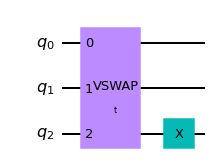

In [23]:
#compare against the known solution, defined backwards
qc_test = QuantumCircuit(3)
qc_test.append(VSwap(Parameter('t')), (0,1,2))
qc_test.x(2)
qc_test.draw(output='mpl')

best state: None 2.1861187439435725


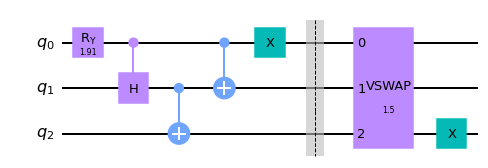

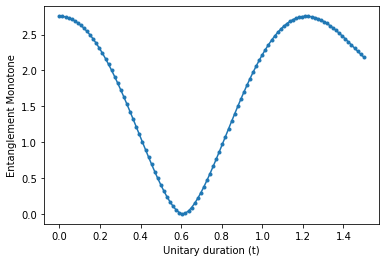

In [24]:
foo_plot4(qc_test, cost_function=objective, t_max=1.5)[0].draw(output='mpl')

final state: [0.0, 0.4999999999999999, 0.5000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0]


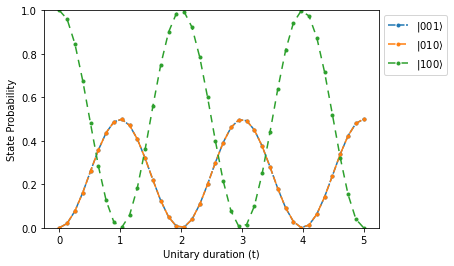

In [25]:
foo(qc_test, t_max=5, invert=True)

Now we want to see if the optimizer can create GHZ state using the DeltaSwap, because this was the most expensive one we foudn by hand

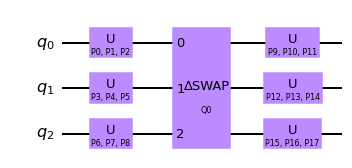

In [26]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import DeltaSwap
del_basis = CircuitTemplateV2(n_qubits=3, base_gates = [DeltaSwap], edge_params=[[(0,1,2)]])
del_basis.build(1)
del_basis.spanning_range = range(1,2)
del_basis.circuit.draw(output='mpl')

In [27]:
ub = 1.0
del_basis.add_bound("Q0", min=0, max=ub)

In [28]:
from src.cost_function import MutualInformation, MutualInformationSquare
objective2 = MutualInformation(state='ghz')
from src.optimizer import TemplateOptimizer
optimizer2 = TemplateOptimizer(basis=del_basis, objective=objective2, use_callback=True, override_fail=True)

In [29]:
#we have the sampler fitting to the unitary instead
#this is used if we want to use a unitary cost function rather than EM
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
ret2 = optimizer2.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 1
INFO:root:Break on cycle 1
INFO:root:Loss=6.466910412977175e-11
INFO:root:Success: (0.49741881, 0.30805173, 0.042267)


Entangled Fidelity 6.466910412977175e-11


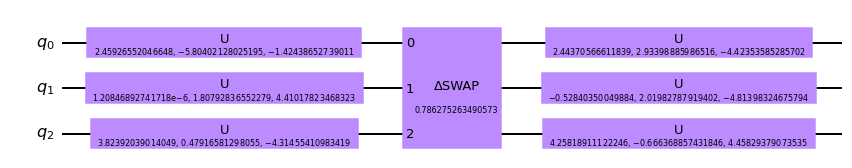

In [30]:
del_basis.build(ret2.cycles)
circuit2 =del_basis.assign_Xk(ret2.Xk)
print("Entangled Fidelity", ret2.loss_result)
circuit2.draw(output='mpl')

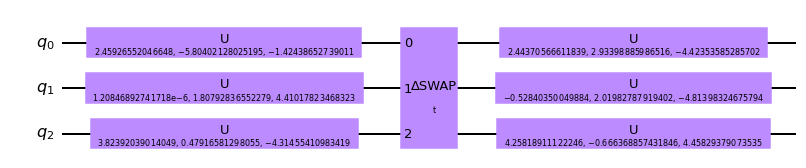

In [31]:
dqc2 = circuit2.copy()
dqc3 = unbind_parameters(dqc2)
#update parameter table
from qiskit.converters import *
dqc3 = dag_to_circuit(circuit_to_dag(dqc3))
# qc3.parameters
dqc3.draw(output='mpl')

best state: 0.7862752634905731 6.466910412977175e-11


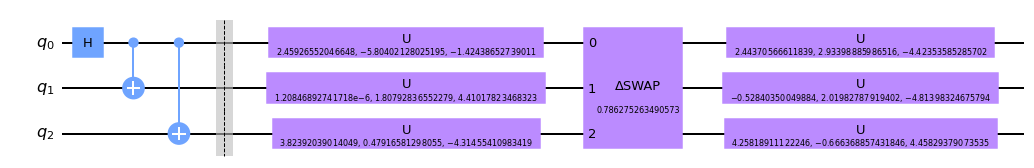

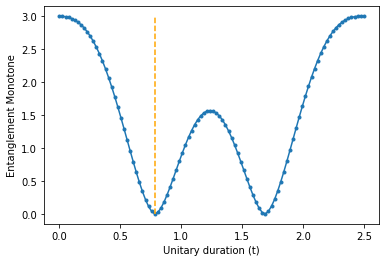

In [32]:
full_dqc3, data_qc3 = foo_plot4(dqc3, cost_function=objective2, t_max=2.5, ret_t = ret2.Xk[-1])
full_dqc3.draw(output='mpl')

final state: [0.07136223652916339, 0.2836713796341554, 0.0044617151672843355, 0.2836713866461082, 0.14050474445886352, 0.004461710959113129, 0.1405047273430273, 0.07136209926228487]


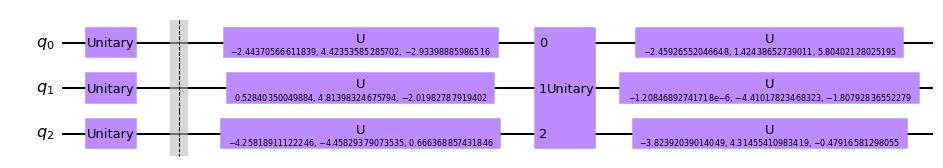

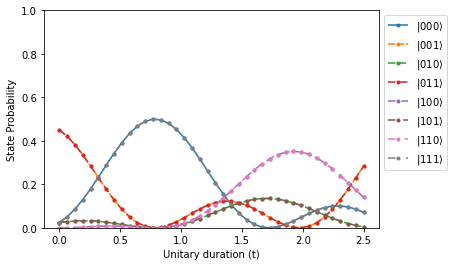

In [33]:
#verify state creation
qc1_prep2 = recover_final_state_prep(full_dqc3)
foo(dqc3, t_max=2.5, invert=True, state_prep=qc1_prep2).draw(output='mpl')

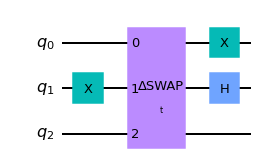

In [34]:
#compare against the known solution, backwards!
qc_test2 = QuantumCircuit(3)
qc_test2.x(1)
qc_test2.append(DeltaSwap(Parameter('t')), (0,1,2))
qc_test2.x(0)
qc_test2.h(1)
qc_test2.draw(output='mpl')

best state: None 2.1632680203073735


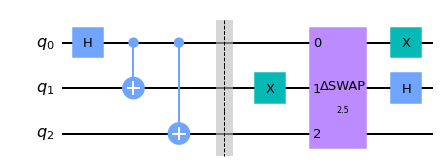

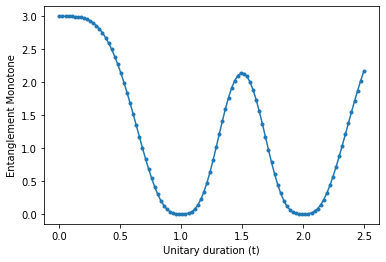

In [35]:
temp_objective = objective2
temp_objective = MutualInformationSquare(state='ghz')
foo_plot4(qc_test2, cost_function=temp_objective, t_max=2.5)[0].draw(output='mpl')

final state: [0.22222222222222254, 0.2222222222222218, 0.0, 0.2222222222222218, 0.055555555555555504, 0.0, 0.055555555555555504, 0.22222222222222254]


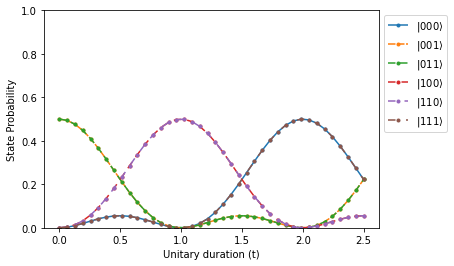

In [36]:
#verify state creation
foo(qc_test2, t_max=2.5, invert=True)

Now we have shown the optimizer can reproduce the 2 known solutions on the V- and Delta-iSwap gates, we want to give it the generic form of the 3Q gates possible and see if it can find a more optimal gate to build each W,GHZ entangled state. 

The major change is that we need a more detailed way to define cost. Before, when time is the only variable, we could just observe that for constant gate params, smaller time is better. Now that gate params are free to be optimized, we define a cost function.

Problem: how do we define a total process fidelity? When we did noisy decomps we could take the product of decompositon fidelity and circuit fidelity. Now, we aren't looking at decomposition fidelity - instead it is just some entangelment monotone so I'm not sure the product of these together is a valid new cost function. 

A straight foward but not practicle way to tackle multi-objective learning is to wrap our optimizer in 2 layers. We want to optimize the cost of the gate in outer loop, optimizer to check if there exists an entanglement solution is in the inside loop.

In [37]:
from src.utils.custom_gates import CirculatorSNAILGate

gate = CirculatorSNAILGate(3,2,1, np.pi/4, np.pi/4, 0, t_el=.5)
gate.cost()

0.5

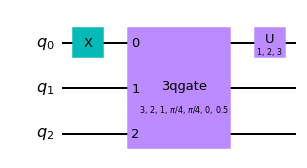

In [38]:
qc = QuantumCircuit(3)
qc.x(0)
qc.append(gate, (0,1,2))
qc.u(1,2,3, 0)
qc.draw(output='mpl')

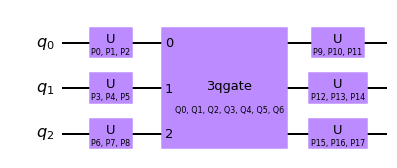

In [39]:
from src.basisv2 import CircuitTemplateV2
f_basis = CircuitTemplateV2(n_qubits=3, base_gates = [CirculatorSNAILGate], edge_params=[[(0,1,2)]])
f_basis.build(1)
f_basis.spanning_range = range(1,2)
f_basis.circuit.draw(output='mpl')

In [40]:
ub = 1.0
f_basis.add_bound("Q6", min=0, max=1.0)

In [41]:
from src.cost_function import MutualInformation, MutualInformationSquare
objective = MutualInformation(state='w')
from src.optimizer import TemplateOptimizer
optimizer3 = TemplateOptimizer(basis=f_basis, objective=objective, use_callback=True, override_fail=True)

In [42]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
ret3 = optimizer3.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 1
INFO:root:Break on cycle 1
INFO:root:Loss=8.989816079768343e-11
INFO:root:Success: (0.49741881, 0.30805173, 0.042267)


Entangled Fidelity 8.989816079768343e-11


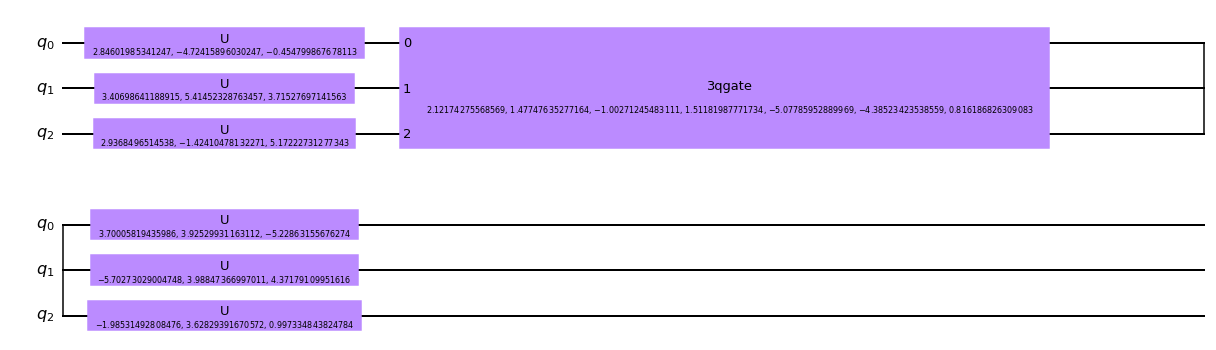

In [43]:
f_basis.build(ret3.cycles)
f_circuit =f_basis.assign_Xk(ret3.Xk)
print("Entangled Fidelity", ret3.loss_result)
f_circuit.draw(output='mpl')

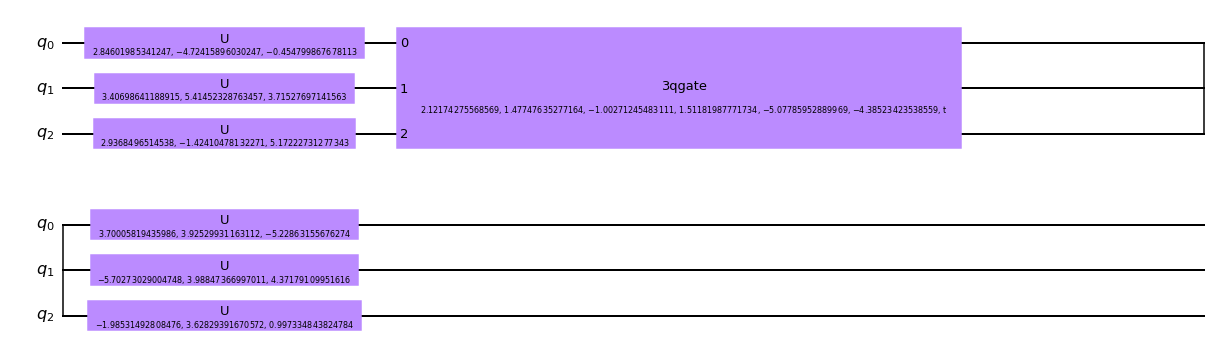

In [44]:
fqc2 = f_circuit.copy()
fqc3 = unbind_parameters(fqc2)
#update parameter table
from qiskit.converters import *
fqc3 = dag_to_circuit(circuit_to_dag(fqc3))
# qc3.parameters
fqc3.draw(output='mpl')

best state: 0.8161868263090832 8.989816079768343e-11


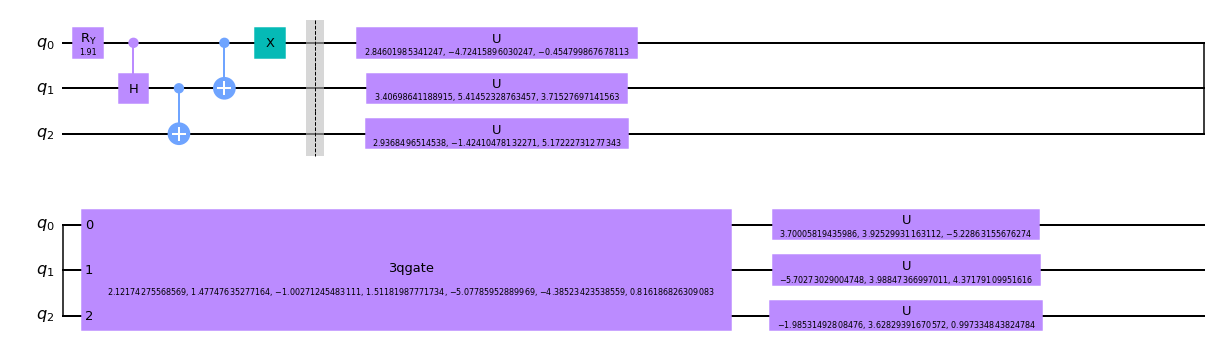

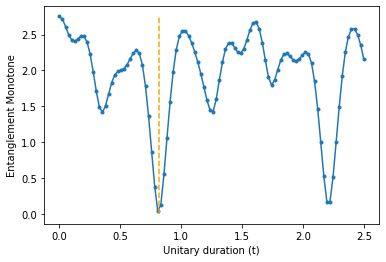

In [45]:
full_fqc3, data_fqc3 = foo_plot4(fqc3, cost_function=objective, t_max=2.5, ret_t = ret3.Xk[-1])
full_fqc3.draw(output='mpl')

final state: [2.0322839561936353e-15, 0.33333350206962264, 0.33333291554248695, 1.8562635188899597e-13, 0.3333335823872928, 1.4227766427164484e-13, 1.3951237680778464e-13, 1.2734144298996055e-13]


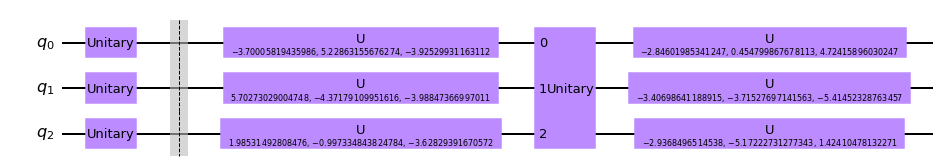

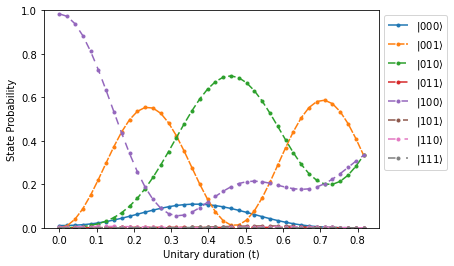

In [46]:
#verify state creation
qc1_prep3 = recover_final_state_prep(full_fqc3)
foo(fqc3, t_max=ret3.Xk[-1] , invert=True, state_prep=qc1_prep3).draw(output='mpl')

Now I am going to attempt my idea to the nested loop optimization problem. Starting with just time as a free parameter, we are going to find a solution, then iterate where each step we define a tigher constraint, shrinking the bound of available times to search.

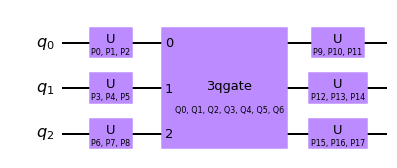

In [47]:
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import CirculatorSNAILGate
f_basis = CircuitTemplateV2(n_qubits=3, base_gates = [CirculatorSNAILGate], edge_params=[[(0,1,2)]])
f_basis.build(1)
f_basis.spanning_range = range(1,2)
f_basis.circuit.draw(output='mpl')

In [48]:
f_basis.circuit_cost(ret3.Xk)
#f_basis.circuit_cost([f_basis.parameter_guess()])
CirculatorSNAILGate(0,100,0,np.pi/2,np.pi/2,np.pi/2,.5).cost()

#the way I am defining cost means that in each iteration we want it to go lower

1.5

In [49]:
ub = 10
f_basis.add_bound("Q0", min=0, max=ub)

In [50]:
ret3 = optimizer.approximate_target_U(s)
print(f_basis.circuit_cost(ret3.Xk))

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 1
INFO:root:Loss=4.1201641257889285e-10


TypeError: ParameterExpression with unbound parameters ({Parameter(Q1)}) cannot be cast to a float.